In [1]:
from google.colab import drive
drive.mount('/content/drive')

file = open('/content/drive/My Drive/Mount.txt', 'r')
mount = file.read()
file.close()

print(mount)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive
Mount successful!


In [2]:
# Load the TensorBoard notebook extension
%load_ext tensorboard

In [3]:
# Clear session
from tensorflow.keras import backend as K
K.clear_session()

In [4]:
!nvidia-smi

Fri Jul 24 09:25:30 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.51.05    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   37C    P8    27W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [5]:
# создаём список директорий к массивам картинок и словарь меток

import datetime
from os import listdir, mkdir
from os.path import isfile, isdir, join, exists
import pickle
import random
import math
import time

def seconds_to_m_s(seconds):
    minutes = math.floor(seconds // 60)
    seconds = math.ceil(seconds % 60)
    return minutes, seconds

# ----------------------------------------------
#            ***  DIRECTORY  ***
base_dir = '/content/drive/My Drive/BF_dataset'
models_dir = join(base_dir, 'models')
logs_dir = join(base_dir, 'logs')

if not exists(logs_dir):
    mkdir(logs_dir)

now_log_dir = join(logs_dir, datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))

if not exists(now_log_dir):
    mkdir(now_log_dir)

model_prefix = 'vehicles_all_'
num_classes = 21
# ==============================================

# ----------------------------------------------
#           ***  LOAD DATA LIST  ***
file = open(join(base_dir, 'train_fold_0.p'), 'rb')
train_list = pickle.load(file)
file.close()

file = open(join(base_dir, 'validation_fold_0.p'), 'rb')
validation_list = pickle.load(file)
file.close()
# ==============================================

In [6]:
from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras import Input

# from tensorflow.keras.applications import InceptionV3

# conv_base = InceptionV3(weights='imagenet', 
#                   include_top = True, 
#                  input_shape=(299, 299, 3))
# conv_base.summary()

# from tensorflow.keras.applications import InceptionResNetV2

# conv_base = InceptionResNetV2(weights='imagenet', 
#                   include_top = True, 
#                  input_shape=(299, 299, 3))
# conv_base.summary()

from tensorflow.keras.applications import VGG16

conv_base = VGG16(weights='imagenet', 
                  include_top = False, 
                 input_shape=(224, 224, 3))
conv_base.summary()

58892288/58889256 [==============================] - 1s 0us/step
Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
______________________________________________________________

In [7]:
from tensorflow.keras.applications.vgg16 import preprocess_input
import tensorflow as tf

input_tensor = Input(shape=(224, 224, 3))
x = conv_base(input_tensor)
x = layers.Flatten()(x)
x = layers.BatchNormalization()(x)
x = layers.Dense(256, activation='relu')(x)
x = layers.Dropout(0.5)(x)
x = layers.BatchNormalization()(x)
output_tensor = layers.Dense(num_classes, activation='softmax')(x)
model = Model(input_tensor, output_tensor)

model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
vgg16 (Model)                (None, 7, 7, 512)         14714688  
_________________________________________________________________
flatten (Flatten)            (None, 25088)             0         
_________________________________________________________________
batch_normalization (BatchNo (None, 25088)             100352    
_________________________________________________________________
dense (Dense)                (None, 256)               6422784   
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 256)               1024  

In [8]:
model.load_weights(join(models_dir, 'vehicles_all_weights_point_13_0.5389.h5'), by_name=False, skip_mismatch=False)

In [ ]:
from tensorflow.keras.utils import plot_model
plot_model(conv_base, show_shapes=True, to_file=join(base_dir, 'model_InceptionResNetV2_01.png'))

In [9]:
# custom generator

from tensorflow.keras.utils import to_categorical
from tensorflow import keras

from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.backend import resize_images
import numpy as np

class DataGenerator(keras.utils.Sequence):
    '''Genarates data for keras'''
    def __init__(self, list_ids, batch_size, dim, n_classes, n_channels = 3, shuffle = True):
        self.list_ids = list_ids
        self.batch_size = batch_size
        self.dim = dim
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.shuffle = shuffle
        self.on_epoch_end()
        # self.open_image

    def __len__(self):
        '''Denotes the number of batches per epoch'''
        return int(np.floor(len(self.list_ids) / self.batch_size))

    def __getitem__(self, index):
        '''Generate one batch of data'''
        # Generate indexes of the batch
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

        # Find list of ids
        list_ids_temp = [self.list_ids[k] for k in indexes]

        # Generate data
        X, y = self.__data_generation(list_ids_temp)

        return X, y

    def on_epoch_end(self):
        '''Updates indexes after each epoch'''
        self.indexes = np.arange(len(self.list_ids))
        if self.shuffle:
            np.random.shuffle(self.indexes)

    def __data_generation(self, list_ids_temp):
        '''Generate data containing batch_size samples'''
        # X: shape (n_samples, *dim, n_channels)

        def open_image(image_path):
            image = load_img(image_path, target_size=self.dim)
            image = img_to_array(image)
            image = image.astype('float32')
            # 'RGB'->'BGR'
            image = image[..., ::-1]
            mean = [103.939, 116.779, 123.68]
            image[..., 0] -= mean[0]
            image[..., 1] -= mean[1]
            image[..., 2] -= mean[2]
            image /= 255.0
            return image

        # Initialization
        X = np.empty((self.batch_size, *self.dim, self.n_channels))
        y = np.empty((self.batch_size), dtype=int)

        # Generate data
        for i, id in enumerate(list_ids_temp):

            # Store sample
            X[i,] = open_image(id[0])

            # Store class
            y[i] = id[1]

        return X, to_categorical(y, num_classes=self.n_classes)

In [10]:
from tensorflow.keras import callbacks

# custom call back: external stop
class ExternalStop(callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        with open('/content/drive/My Drive/BF_dataset/logs/external_stop_training.txt', 'r') as file:
            if int(file.readline()) == 1:
                print('External stop training')
                self.model.stop_training = True

In [11]:
print(len(conv_base.layers))

# 0) random weights

# 1) unfreeze all layers
conv_base.trainable = False

# 2) freeze all layers
# conv_base.trainable = False

# 3) unfreeze half layers
border = 15

for i, layer in enumerate(conv_base.layers):
    if i < border:
        layer.trainable = False
    else:
        layer.trainable = True

for layer in conv_base.layers:
    print(layer, layer.trainable)

print(len(conv_base.trainable_weights))

19
<tensorflow.python.keras.engine.input_layer.InputLayer object at 0x7f4e1f9c8e10> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f4e21a87278> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f4e21a87b38> False
<tensorflow.python.keras.layers.pooling.MaxPooling2D object at 0x7f4e21a86668> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f4e21a7ce10> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f4e22000ba8> False
<tensorflow.python.keras.layers.pooling.MaxPooling2D object at 0x7f4e611f8710> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f4e611f87f0> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f4e611f9c88> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f4e612049e8> False
<tensorflow.python.keras.layers.pooling.MaxPooling2D object at 0x7f4e6226b940> False
<tensorflow.python.keras.layers.convolutional.Conv2D object 

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import TensorBoard, EarlyStopping, ModelCheckpoint
from tensorflow.keras import optimizers

train_steps_per_epoch = len(train_list) // 32
validation_steps_per_epoch = len(validation_list) // 20

print('train_steps_per_epoch = ', train_steps_per_epoch)
print('validation_steps_per_epoch = ', validation_steps_per_epoch)

start_work = time.time()

logs_dir = join(base_dir, 'logs')

with open('/content/drive/My Drive/BF_dataset/logs/external_stop_training.txt', 'w') as file:
    file.write('0')

# Parameters
params_train = {'dim': (224, 224),
                'batch_size': 32,
                'n_classes': 21,
                'n_channels': 3,
                'shuffle': True}

params_validation = {'dim': (224, 224),
                     'batch_size': 20,
                     'n_classes': 21,
                     'n_channels': 3,
                     'shuffle': True}

train_generator = DataGenerator(train_list, **params_train)
validation_generator = DataGenerator(validation_list, **params_validation)

model.compile(optimizer=optimizers.Adam(learning_rate=1e-4),
              loss='categorical_crossentropy',
              metrics=['acc'])

# Calbacks 
tensor_board = TensorBoard(now_log_dir, histogram_freq=1)
early_stopping = EarlyStopping(monitor='val_acc', patience=5)


checkpoint_filepath = join(models_dir, 'vehicles_all_weights_point_{epoch:02d}_{val_acc:.4f}.h5')
model_check_point = ModelCheckpoint(checkpoint_filepath, monitor='val_acc', verbose=1, save_weights_only=True, 
                                    save_best_only=True, mode='auto', save_freq='epoch')

external_stop = ExternalStop()

callback = [tensor_board, 
            early_stopping, 
            model_check_point,
            external_stop]

history = model.fit(train_generator,
                    steps_per_epoch=train_steps_per_epoch,
                    epochs=20,
                    initial_epoch=14,
                    validation_data=validation_generator,
                    validation_steps=validation_steps_per_epoch,
                    callbacks=callback)

end_work = time.time()
work_time = seconds_to_m_s(end_work - start_work)
print("\nAll work took {} minutes {} seconds".format(work_time[0], work_time[1]))

train_steps_per_epoch =  1113
validation_steps_per_epoch =  420
Epoch 15/20
1113/1113 [==============================] - ETA: 0s - loss: 0.4861 - acc: 0.8468 
Epoch 00015: val_acc improved from -inf to 0.53202, saving model to /content/drive/My Drive/BF_dataset/models/vehicles_all_weights_point_15_0.5320.h5
1113/1113 [==============================] - 34673s 31s/step - loss: 0.4861 - acc: 0.8468 - val_loss: 1.6339 - val_acc: 0.5320
Epoch 16/20
 347/1113 [========>.....................] - ETA: 46:39 - loss: 0.4329 - acc: 0.8667

In [ ]:
model.save_weights(join(models_dir, model_prefix + 'weights_freeze_epochs_20_01.h5'))

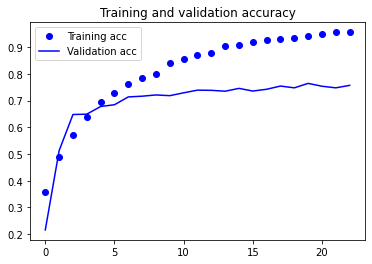

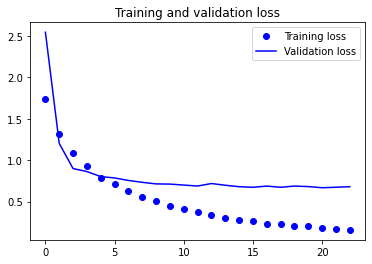

In [ ]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [ ]:
from tensorflow.keras.utils import plot_model
plot_model(model, show_shapes=True, to_file=join(base_dir, 'model_graph_06.png'))

In [ ]:
print(now_log_dir)

/content/drive/My Drive/Tanks_416/logs/20200509-071648


In [ ]:
%tensorboard --logdir '/content/drive/My Drive/Tanks_416/logs/20200509-071648'

In [ ]:
test_loss, test_acc = model.evaluate(validation_generator, steps=80)
print('test acc:', test_acc)

80/80 [==============================] - 16s 195ms/step - loss: 0.5408 - acc: 0.7850
test acc: 0.7850000262260437
